In [22]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import gc
import torchsummary
from datetime import datetime
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [23]:
#torch seed and device info
torch.random.manual_seed(0)
!nvidia-smi

Thu Oct  9 18:44:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500               Off |   00000000:01:00.0 Off |                  Off |
| 30%   30C    P8             22W /  230W |      14MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A5500 (UUID: GPU-8dd8bd39-a66b-8aa3-ce58-81c5e214a054)
GPU 1: NVIDIA RTX A5500 (UUID: GPU-0d143765-9b0e-0a6a-0f03-2a9a43a39889)
GPU 2: NVIDIA RTX A5500 (UUID: GPU-cd01c66c-b823-0ed5-f79c-20e623459232)


In [25]:
# Paths and data split
imagesGreenSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/GreenSeason/Tiles"
masksGreenSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/GreenSeason/Masks"
imagesDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Tiles"
masksDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Masks"
BaseWeightPath = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weightsTrainDS/weights_20250818_105543.pth"
weightsGreenSeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/GreenSeason/Weights"
weightsDrySeason = "/home/lcervantes/Dataset/Datasets/AndeanCrops/DrySeason/Weights"
predictionsGreenSeason = "/home/lcervantes/Dataset/AndeanCrops/GreenSeason/Predictions"
predictionsGreenSeason = "/home/lcervantes/Dataset/AndeanCrops/DrySeason/Predictions"

# Split from train and test - Green Season

 Base model is used here

In [26]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [27]:
imageGreen = sorted(glob.glob(imagesGreenSeason + "/*.tif"))
maskGreen = sorted(glob.glob(masksGreenSeason + "/*.png"))
trainTilesGreen, testTilesGreen, trainGreenMasks, testGreenMasks = train_test_split(
    imageGreen, maskGreen, test_size=0.3, random_state=42
)

trainGreenDS = FourBandSegmentationDataset(imagesGreenSeason, masksGreenSeason, files_list=(trainTilesGreen, trainGreenMasks))
testGreenDS = FourBandSegmentationDataset(imagesGreenSeason, masksGreenSeason, files_list=(testTilesGreen, testGreenMasks))

In [28]:
batch_size = 4
trainloaderGreen = DataLoader(trainGreenDS, batch_size=batch_size, shuffle=True)
testloaderGreen = DataLoader(testGreenDS, batch_size=batch_size, shuffle=True)

In [29]:
len(trainGreenDS),len(testGreenDS)

(327, 141)

## Model for NN:

In [30]:
inputBands = 4
outputBands=1

In [31]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

In [32]:
class UNet(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [33]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [34]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [35]:
#Losses:

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss
    
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        return 1 - tversky

In [36]:
model = UNet(in_channels=inputBands, out_channels=outputBands).to(device)
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 20

In [37]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [38]:
# load weights in model
model.load_state_dict(torch.load(BaseWeightPath, map_location=device))

<All keys matched successfully>

## Model evaluation - Pre-training

In [39]:
# Eval model before training - test generalization
model.eval()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [40]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

def compute_metrics_batch(pred, target):
    # pred y target: (batch, 1, H, W) or (batch, H, W)
    batch_size = pred.shape[0]
    results = {"Jaccard": [], "Dice": [], "Precision": [], "Recall": []}
    for i in range(batch_size):
        p = pred[i].cpu().numpy().astype(np.uint8).flatten()
        t = target[i].cpu().numpy().astype(np.uint8).flatten()
        results["Jaccard"].append(jaccard_score(t, p, zero_division=0))
        results["Dice"].append(f1_score(t, p, zero_division=0))
        results["Precision"].append(precision_score(t, p, zero_division=0))
        results["Recall"].append(recall_score(t, p, zero_division=0))
    # Average batch metrics
    return {k: np.mean(v) for k, v in results.items()}

In [41]:
predict_th = 0.5

In [42]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in trainloaderGreen:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics_batch(pred, mask)
        metrics_list.append(metrics)

In [43]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.3783
Dice: 0.5068
Precision: 0.4503
Recall: 0.7327


In [44]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderGreen:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [45]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.3511
Dice: 0.5054
Precision: 0.4150
Recall: 0.7237


## Finding LR

In [77]:
def lrFinder(model, optimizer_class, criterion, dataloader, device, 
                     start_lr=1e-7, end_lr=1, num_iter=100):
    model.train()
    lrs = []
    losses = []

    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr

    optimizer = optimizer_class(model.parameters(), lr=lr)
    iter_count = 0

    for inputs, targets in dataloader:
        if iter_count > num_iter:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(lr)
        losses.append(loss.item())

        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        iter_count += 1

    return lrs, losses

Device: cuda:2


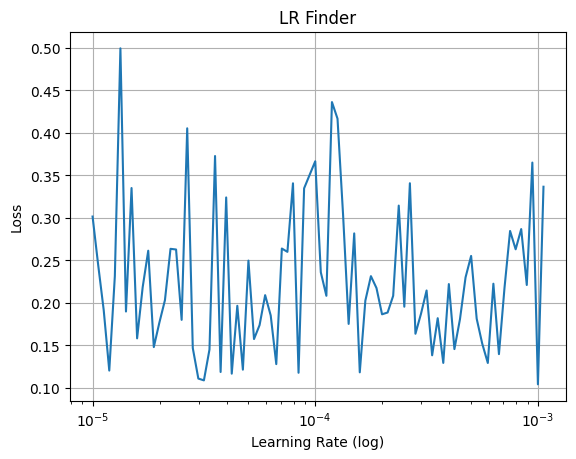

In [78]:
print(f"Device: {device}")
lrs, losses = lrFinder(model, torch.optim.AdamW, TverskyLoss(), trainloaderGreen, device,start_lr=1e-5,num_iter=200)

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (log)")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.grid()
plt.show()

## Training new model with data

In [46]:
model.train()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(

In [47]:
#Train loop:
def get_accuracy(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def get_jaccard(preds, targets, threshold=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

def train_model(model, loss_function, optimizer, epochs, train_loader, test_loader, device,patience=5, save_path=None):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        #train_acc = 0.0
        train_jaccard = 0.0
        n_train = 0

        for imgs, masks in train_loader:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            loss.backward()
            optimizer.step()
            batch_size = imgs.size(0)
            train_loss += loss.item() * batch_size
            #train_acc += get_accuracy(outputs, masks) * batch_size
            train_jaccard += get_jaccard(outputs, masks) * batch_size
            n_train += batch_size

        train_loss /= n_train
        #train_acc /= n_train
        train_jaccard /= n_train
        train_losses.append(train_loss)
        #train_accuracies.append(train_acc.cpu().item())
        train_accuracies.append(train_jaccard.cpu().item())

        model.eval()
        test_loss = 0.0
        #test_acc = 0.0
        test_jaccard = 0.0
        n_test = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs = imgs.to(device).float()
                masks = masks.to(device).float()
                outputs = model(imgs)
                loss = loss_function(outputs, masks)
                batch_size = imgs.size(0)
                test_loss += loss.item() * batch_size
                #test_acc += get_accuracy(outputs, masks) * batch_size
                test_jaccard += get_jaccard(outputs, masks) * batch_size
                n_test += batch_size

        test_loss /= n_test
        #test_acc /= n_test
        test_jaccard /= n_test
        test_losses.append(test_loss)
        #test_accuracies.append(test_acc.cpu().item())
        test_accuracies.append(test_jaccard.cpu().item())

        #print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:.4f}")
        print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - acc: {train_jaccard:.4f} - val_loss: {test_loss:.4f} - val_acc: {test_jaccard:.4f}")

        if save_path is not None:
            # Early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_path)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [48]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
bestModel = os.path.join(weightsGreenSeason, f"weights_{timestamp}.pth")
os.makedirs(os.path.dirname(bestModel), exist_ok=True)

In [49]:
bestModel

'/home/lcervantes/Dataset/Datasets/AndeanCrops/GreenSeason/Weights/weights_20251009_184622.pth'

In [50]:
print(device)

cuda:2


In [51]:
# Entrenamiento
#criterion = BCEDiceLoss()
criterion = TverskyLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
epochs = 30

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, criterion, optimizer, epochs, trainloaderGreen, testloaderGreen, device,patience = 5,save_path=bestModel
)

Epoch 1/30 - loss: 0.3350 - acc: 0.5081 - val_loss: 0.3704 - val_acc: 0.4736
Epoch 2/30 - loss: 0.3097 - acc: 0.5379 - val_loss: 0.3315 - val_acc: 0.5082
Epoch 3/30 - loss: 0.2971 - acc: 0.5547 - val_loss: 0.3117 - val_acc: 0.5336
Epoch 4/30 - loss: 0.2893 - acc: 0.5630 - val_loss: 0.3020 - val_acc: 0.5429
Epoch 5/30 - loss: 0.2771 - acc: 0.5765 - val_loss: 0.2997 - val_acc: 0.5496
Epoch 6/30 - loss: 0.2594 - acc: 0.5964 - val_loss: 0.3054 - val_acc: 0.5413
Epoch 7/30 - loss: 0.2669 - acc: 0.5853 - val_loss: 0.3012 - val_acc: 0.5507
Epoch 8/30 - loss: 0.2614 - acc: 0.5931 - val_loss: 0.2976 - val_acc: 0.5527
Epoch 9/30 - loss: 0.2642 - acc: 0.5928 - val_loss: 0.3072 - val_acc: 0.5395
Epoch 10/30 - loss: 0.2687 - acc: 0.5831 - val_loss: 0.2908 - val_acc: 0.5590
Epoch 11/30 - loss: 0.2591 - acc: 0.5985 - val_loss: 0.2938 - val_acc: 0.5574
Epoch 12/30 - loss: 0.2512 - acc: 0.6072 - val_loss: 0.2776 - val_acc: 0.5743
Epoch 13/30 - loss: 0.2501 - acc: 0.6115 - val_loss: 0.2770 - val_acc: 0.

In [52]:
def show_results(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(train_losses, label='train')
    ax1.plot(test_losses, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(test_accuracies, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

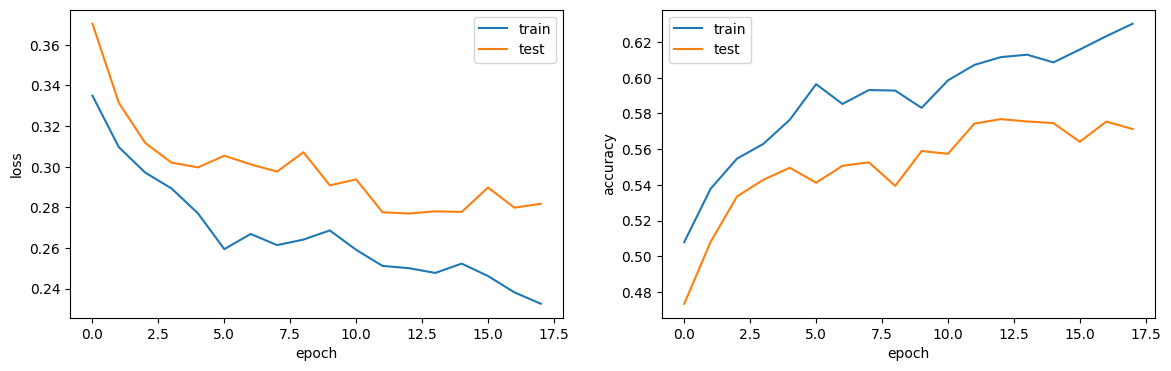

In [53]:
# Visualize
show_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [54]:
predict_th = 0.5

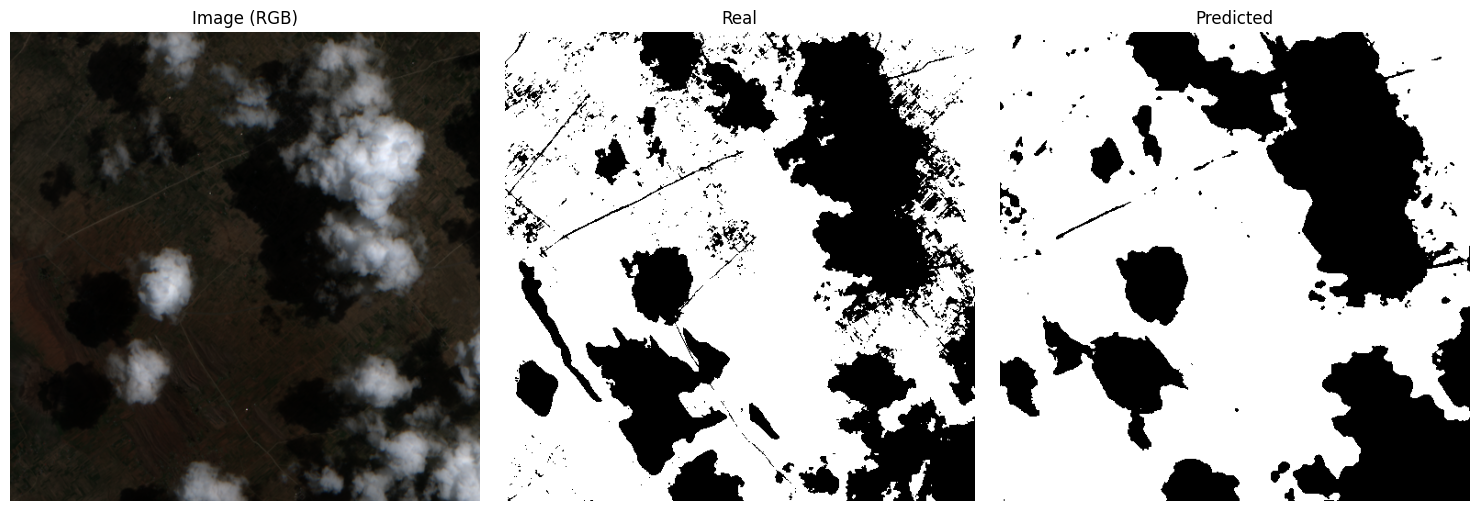

In [69]:
# Eval and visualize
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(testloaderGreen))
    imgs = imgs.to(device)
    outputs = model(imgs)
    pred_mask = (outputs[0] > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Evaluation post - training

In [70]:
# modelToEvalPath = "/home/lcervantes/Dataset/Datasets/AndeanCrops/GreenSeason/Weights/weights_20251009_175857.pth"
# model.load_state_dict(torch.load(modelToEvalPath, map_location=device))

In [71]:
device

device(type='cuda', index=2)

In [72]:
predict_th = 0.5

In [73]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderGreen:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [74]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.5791
Dice: 0.7253
Precision: 0.7236
Recall: 0.7448


In [75]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in testloaderGreen:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [76]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.5848
Dice: 0.7306
Precision: 0.7348
Recall: 0.7410
